In [1]:
import tensorflow as tf
from tensorflow.keras.models import load_model
from sklearn.decomposition import PCA
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import StandardScaler
import joblib
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV


In [2]:
# Load the trained CNN model
cnn_model_path = r"C:\Users\K M SASTRY\Desktop\CAPSTONE PROJECT\cnn_model.h5"
cnn_model = load_model(cnn_model_path)

# Extract features from CNN's 'flatten' layer
cnn_model = tf.keras.Model(inputs=cnn_model.input, outputs=cnn_model.get_layer('flatten').output)

# Freeze CNN layers
for layer in cnn_model.layers:
    layer.trainable = False


In [3]:
# Image directories
train_dir = r"K:\PROJECT\ORGANISED DATASET\train"
test_dir = r"K:\PROJECT\ORGANISED DATASET\test"

# Image Preprocessing
train_datagen = ImageDataGenerator(rescale=1.0 / 255.0)
test_datagen = ImageDataGenerator(rescale=1.0 / 255.0)

train_generator = train_datagen.flow_from_directory(
    train_dir, target_size=(224, 224), batch_size=32, class_mode='binary', shuffle=False
)
test_generator = test_datagen.flow_from_directory(
    test_dir, target_size=(224, 224), batch_size=32, class_mode='binary', shuffle=False
)


Found 6185 images belonging to 2 classes.
Found 1724 images belonging to 2 classes.


In [4]:
# Feature Extraction
def extract_features(generator, model):
    features = model.predict(generator, verbose=1)
    labels = generator.classes
    return features, labels

train_features, train_labels = extract_features(train_generator, cnn_model)
test_features, test_labels = extract_features(test_generator, cnn_model)

print(f"Original feature dimensions: {train_features.shape[1]}")

54/54 [==============================] - 107s 2s/step
Original feature dimensions: 86528


In [5]:
# Scale features
scaler = StandardScaler()
train_features_scaled = scaler.fit_transform(train_features)
test_features_scaled = scaler.transform(test_features)

# Apply PCA (retain 95% variance)
pca = PCA(n_components=0.95, random_state=42)
train_features_pca = pca.fit_transform(train_features_scaled)
test_features_pca = pca.transform(test_features_scaled)

print(f"Reduced feature dimensions (PCA): {train_features_pca.shape[1]}")

Reduced feature dimensions (PCA): 389


In [6]:
# Define XGBoost Classifier with initial parameters
xgb_classifier = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False,
    random_state=42
)


In [7]:
# Hyperparameter tuning with GridSearchCV
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

In [8]:
grid_search = GridSearchCV(xgb_classifier, param_grid, cv=3, scoring='accuracy', n_jobs=-1, verbose=1)
grid_search.fit(train_features_pca, train_labels)

# Get the best XGBoost model
best_xgb = grid_search.best_estimator_

print(f"Best Parameters: {grid_search.best_params_}")
print("XGBoost model trained using CNN features with PCA.")

Fitting 3 folds for each of 72 candidates, totalling 216 fits


C:\Users\K M SASTRY\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:33:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best Parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}
XGBoost model trained using CNN features with PCA.


In [9]:
# Predict on the test set
test_predictions = best_xgb.predict(test_features_pca)

# Compute accuracy
accuracy = accuracy_score(test_labels, test_predictions)
print(f"Test Accuracy with PCA & XGBoost: {accuracy:.4f}")


Test Accuracy with PCA & XGBoost: 0.8683


In [10]:
# Classification report
print("Classification Report with XGBoost:")
print(classification_report(test_labels, test_predictions, target_names=test_generator.class_indices.keys()))

Classification Report with XGBoost:
              precision    recall  f1-score   support

      BENIGN       0.84      0.72      0.77       542
   MALIGNANT       0.88      0.94      0.91      1182

    accuracy                           0.87      1724
   macro avg       0.86      0.83      0.84      1724
weighted avg       0.87      0.87      0.87      1724



In [11]:
xgb_model_path = r'C:\Users\K M SASTRY\Desktop\CAPSTONE PROJECT\xgb_model_with_pca.pkl'
pca_model_path = r'C:\Users\K M SASTRY\Desktop\CAPSTONE PROJECT\pca_model.pkl'
scaler_model_path = r'C:\Users\K M SASTRY\Desktop\CAPSTONE PROJECT\scaler_with_pca.pkl'

joblib.dump(best_xgb, xgb_model_path)
joblib.dump(pca, pca_model_path)
joblib.dump(scaler, scaler_model_path)

print(f"XGBoost model saved at {xgb_model_path}")
print(f"PCA model saved at {pca_model_path}")
print(f"Scaler saved at {scaler_model_path}")

XGBoost model saved at C:\Users\K M SASTRY\Desktop\CAPSTONE PROJECT\xgb_model_with_pca.pkl
PCA model saved at C:\Users\K M SASTRY\Desktop\CAPSTONE PROJECT\pca_model.pkl
Scaler saved at C:\Users\K M SASTRY\Desktop\CAPSTONE PROJECT\scaler_with_pca.pkl


1/1 [==============================] - 0s 77ms/step


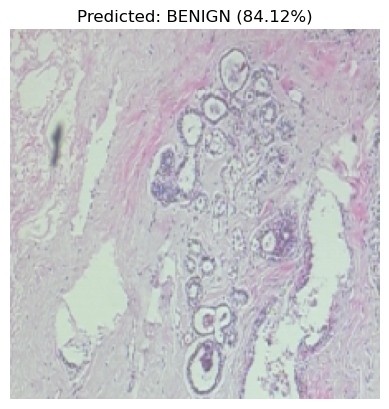

Prediction Probabilities:
BENIGN: 0.84
MALIGNANT: 0.16


In [14]:
import numpy as np
import joblib
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from xgboost import XGBClassifier

# Load the trained models
cnn_model = load_model(r"C:\Users\K M SASTRY\Desktop\CAPSTONE PROJECT\cnn_model.h5")
cnn_model = tf.keras.Model(inputs=cnn_model.input, outputs=cnn_model.get_layer('flatten').output)

scaler = joblib.load(r'C:\Users\K M SASTRY\Desktop\CAPSTONE PROJECT\scaler_with_pca.pkl')
pca = joblib.load(r'C:\Users\K M SASTRY\Desktop\CAPSTONE PROJECT\pca_model.pkl')
xgb_classifier = joblib.load(r'C:\Users\K M SASTRY\Desktop\CAPSTONE PROJECT\xgb_model_with_pca.pkl')

# Class labels mapping
class_indices = {'BENIGN': 0, 'MALIGNANT': 1}
reverse_class_indices = {v: k for k, v in class_indices.items()}

def predict_image(image_path):
    """Predict the class of a single image using the trained CNN+PCA+XGBoost model."""
    # Load and preprocess the image
    img = load_img(image_path, target_size=(224, 224))
    img_array = img_to_array(img) / 255.0  # Normalize
    img_array = np.expand_dims(img_array, axis=0)

    # Extract features using CNN
    features = cnn_model.predict(img_array)
    
    # Apply scaling and PCA transformation
    features_scaled = scaler.transform(features)
    features_pca = pca.transform(features_scaled)
    
    # Predict using XGBoost
    prediction = xgb_classifier.predict(features_pca)
    probabilities = xgb_classifier.predict_proba(features_pca)[0]

    # Get predicted class and confidence
    predicted_class = reverse_class_indices[prediction[0]]
    confidence = max(probabilities)

    # Display image with prediction
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Predicted: {predicted_class} ({confidence * 100:.2f}%)")
    plt.show()

    # Print probability scores
    print("Prediction Probabilities:")
    for class_label, prob in zip(reverse_class_indices.values(), probabilities):
        print(f"{class_label}: {prob:.2f}")

# Example usage
image_path = r"K:\PROJECT\ORGANISED DATASET\test\BENIGN\adenosis\SOB_B_A_14-22549AB\40X\SOB_B_A-14-22549AB-40-001.png"
predict_image(image_path)


1/1 [==============================] - 0s 79ms/step


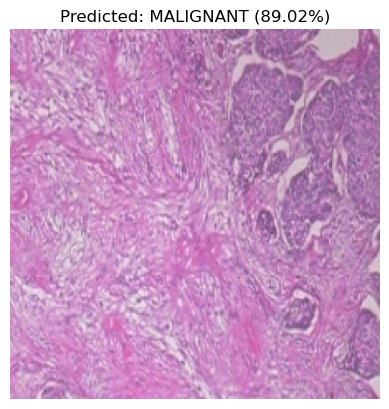

Prediction Probabilities:
BENIGN: 0.11
MALIGNANT: 0.89


In [13]:
import numpy as np
import joblib
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from xgboost import XGBClassifier

# Load the trained models
cnn_model = load_model(r"C:\Users\K M SASTRY\Desktop\CAPSTONE PROJECT\cnn_model.h5")
cnn_model = tf.keras.Model(inputs=cnn_model.input, outputs=cnn_model.get_layer('flatten').output)

scaler = joblib.load(r'C:\Users\K M SASTRY\Desktop\CAPSTONE PROJECT\scaler_with_pca.pkl')
pca = joblib.load(r'C:\Users\K M SASTRY\Desktop\CAPSTONE PROJECT\pca_model.pkl')
xgb_classifier = joblib.load(r'C:\Users\K M SASTRY\Desktop\CAPSTONE PROJECT\xgb_model_with_pca.pkl')

# Class labels mapping
class_indices = {'BENIGN': 0, 'MALIGNANT': 1}
reverse_class_indices = {v: k for k, v in class_indices.items()}

def predict_image(image_path):
    """Predict the class of a single image using the trained CNN+PCA+XGBoost model."""
    # Load and preprocess the image
    img = load_img(image_path, target_size=(224, 224))
    img_array = img_to_array(img) / 255.0  # Normalize
    img_array = np.expand_dims(img_array, axis=0)

    # Extract features using CNN
    features = cnn_model.predict(img_array)
    
    # Apply scaling and PCA transformation
    features_scaled = scaler.transform(features)
    features_pca = pca.transform(features_scaled)
    
    # Predict using XGBoost
    prediction = xgb_classifier.predict(features_pca)
    probabilities = xgb_classifier.predict_proba(features_pca)[0]

    # Get predicted class and confidence
    predicted_class = reverse_class_indices[prediction[0]]
    confidence = max(probabilities)

    # Display image with prediction
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Predicted: {predicted_class} ({confidence * 100:.2f}%)")
    plt.show()

    # Print probability scores
    print("Prediction Probabilities:")
    for class_label, prob in zip(reverse_class_indices.values(), probabilities):
        print(f"{class_label}: {prob:.2f}")

# Example usage
image_path = r"K:\PROJECT\ORGANISED DATASET\test\MALIGNANT\ductal_carcinoma\SOB_M_DC_14-2523\40X\SOB_M_DC-14-2523-40-016.png"
predict_image(image_path)
